<a href="https://colab.research.google.com/github/hangjoni/hanoi-food-classifier/blob/master/Chapter_2_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 22.0 MB/s 
     |████████████████████████████████| 346 kB 71.0 MB/s 
     |████████████████████████████████| 197 kB 57.5 MB/s 
     |████████████████████████████████| 4.2 MB 49.3 MB/s 
     |████████████████████████████████| 1.2 MB 40.5 MB/s 
     |████████████████████████████████| 60 kB 6.3 MB/s 
     |████████████████████████████████| 212 kB 74.1 MB/s 
     |████████████████████████████████| 140 kB 75.6 MB/s 
     |████████████████████████████████| 1.1 MB 57.7 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
     |████████████████████████████████| 127 kB 69.2 MB/s 
     |████████████████████████████████| 271 kB 73.1 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 74.3 MB/s 
     |████████████████████████████████| 112 kB 59.1 MB/s 
     |████████████████

In [2]:
from fastbook import * 
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '9c29e9472ed34742a4502a6b73468202')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

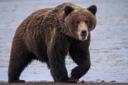

In [7]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [8]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [9]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#209) [Path('bears/grizzly/00000063.jpg'),Path('bears/grizzly/00000142.jpg'),Path('bears/grizzly/00000065.jpg'),Path('bears/grizzly/00000107.png'),Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000053.jpg'),Path('bears/grizzly/00000033.jpg'),Path('bears/grizzly/00000089.jpg'),Path('bears/grizzly/00000113.jpg'),Path('bears/grizzly/00000004.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#5) [Path('bears/grizzly/00000096.jpg'),Path('bears/grizzly/00000098.jpg'),Path('bears/grizzly/00000075.jpg'),Path('bears/teddy/00000009.jpg'),Path('bears/teddy/00000030.jpg')]

In [12]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [13]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [14]:
dls = bears.dataloaders(path)

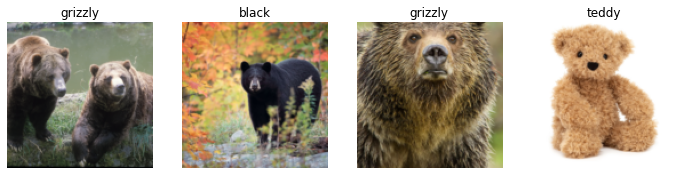

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

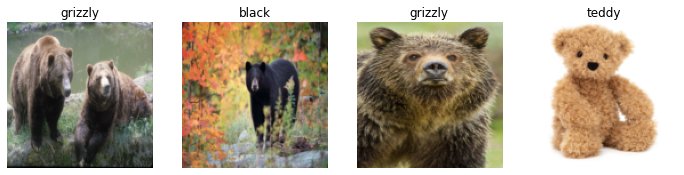

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

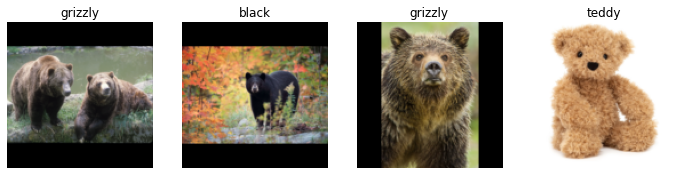

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

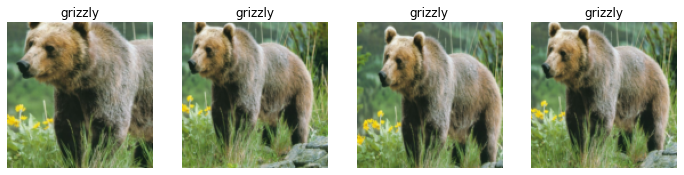

In [18]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

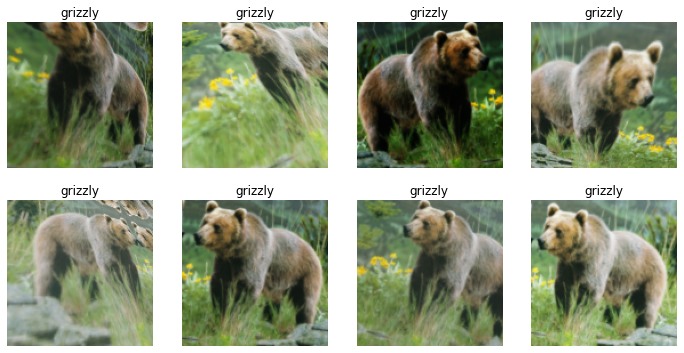

In [19]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [20]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)


In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.212190,0.445789,0.175000,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.217583,0.198771,0.050000,00:16
1,1.040100,0.098503,0.000000,00:17
2,0.812681,0.073694,0.025000,00:16
3,0.655033,0.060373,0.025000,00:16


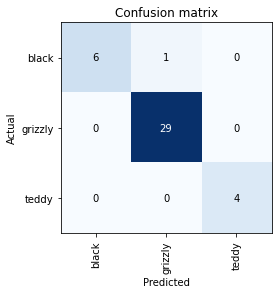

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

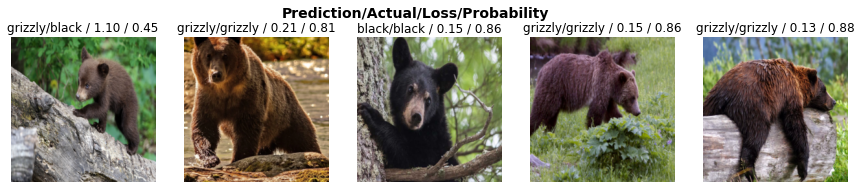

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')

In [28]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([0.0109, 0.9686, 0.0205]))

In [29]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [30]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [31]:
btn_upload = SimpleNamespace(data=['images/grizzly.jpg'])

In [32]:
img = PILImage.create(btn_upload.data[-1])

In [33]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
pred,pred_idx,probs = learn_inf.predict(img)

In [35]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9686')

In [36]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
btn_upload = widgets.FileUpload()

In [39]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [40]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 17.2 MB/s 
     |████████████████████████████████| 132 kB 56.8 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 344 kB 64.5 MB/s 
     |████████████████████████████████| 70 kB 9.2 MB/s 
     |████████████████████████████████| 112 kB 24.2 MB/s 
     |████████████████████████████████| 561 kB 64.9 MB/s 
     |████████████████████████████████| 428 kB 64.4 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 133 kB 64.7 MB/s 
  Created wheel for json5: filename=json5-0.9.8-py2.py3-none-any.whl size=18604 sha256=157dc26ef0535925b4aeee2b0d8d11f8c326c5bc4675adb9cb5587725b33726d
  Stored in directory: /root/.cache/pip/wheels/ac/9b/de/6e4fd8f159d3dfa42c42ceddf2184fda29ea7fb1e8f5f8371c
Successfull

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila  OK
